<a href="https://colab.research.google.com/github/karoline-juliana/simpsons_nlp/blob/main/simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Técnico.
## NLP com Os Simpsons.
Projeto de Processamento de Linguagem Natural para um conjunto de dados composto por mais de 75 mil frases dos principais personagens de “Os Simpsons”, ditas ao longo de 600 episódios. Já foi separado os dados em um dataset de treino e outro de teste (67% e 33% dos dados, respectivamente).

O objetivo do case foi estimar o personagem mais provável de ter dito uma frase qualquer, que não necessariamente já foi falada na série, sendo estimada pelo modelo.

Obs.: É necessário rodar o notebook com GPUs.

Autora: Karoline Juliana Costa da Silva.

In [9]:
!python -m spacy download en_core_web_lg
!pip3 install ktrain

     |████████████████████████████████| 827.9 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [10]:
import os.path
import keras
from nltk.tokenize import TweetTokenizer
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from time import time 
from collections import defaultdict 
from datetime import datetime
import os
import codecs
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import string
import spacy
import en_core_web_lg
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import ktrain
from ktrain import text
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [11]:
simpsons_test = pd.read_csv("https://raw.githubusercontent.com/karoline-juliana/simpsons_nlp/main/dataset/simpsons_test.csv", sep = ",")
simpsons_train = pd.read_csv("https://raw.githubusercontent.com/karoline-juliana/simpsons_nlp/main/dataset/simpsons_train.csv", sep = ",")

In [12]:
df = pd.concat(objs = [simpsons_train, simpsons_test], axis = 0).reset_index(drop=True)

In [13]:
df.head()

,character_id,character_name,spoken_words
0,1,Marge Simpson,"Marge Simpson - Homie, it's eleven at night. H..."
1,5,Lisa Simpson,Lisa Simpson - Looks like we're back to travel...
2,0,Homer Simpson,"Homer Simpson - Whew, I'd hate to be that kid'..."
3,0,Homer Simpson,"Homer Simpson - Yes, that's a real pickle. Wou..."
4,4,Milhouse Van Houten,"Milhouse Van Houten - Hey Bart, I finished org..."


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75685 entries, 0 to 75684
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   character_id    75685 non-null  int64 
 1   character_name  75685 non-null  object
 2   spoken_words    75685 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Distribuição dos personagens
df.groupby('character_name').count()

,character_id,spoken_words
character_name,,
Bart Simpson,11726,11726
C. Montgomery Burns,2886,2886
Chief Wiggum,1711,1711
Grampa Simpson,1693,1693
Homer Simpson,25519,25519
Krusty the Clown,1622,1622
Lisa Simpson,9832,9832
Marge Simpson,12169,12169
Milhouse Van Houten,1607,1607


In [16]:
personagens = df['character_name'].value_counts(ascending=False).reset_index()
personagens = personagens.rename(columns = {'index':'character_name', 'character_name':'frequency'})
personagens

,character_name,frequency
0,Homer Simpson,25519
1,Marge Simpson,12169
2,Bart Simpson,11726
3,Lisa Simpson,9832
4,C. Montgomery Burns,2886
5,Moe Szyslak,2681
6,Seymour Skinner,2283
7,Ned Flanders,1956
8,Chief Wiggum,1711
9,Grampa Simpson,1693


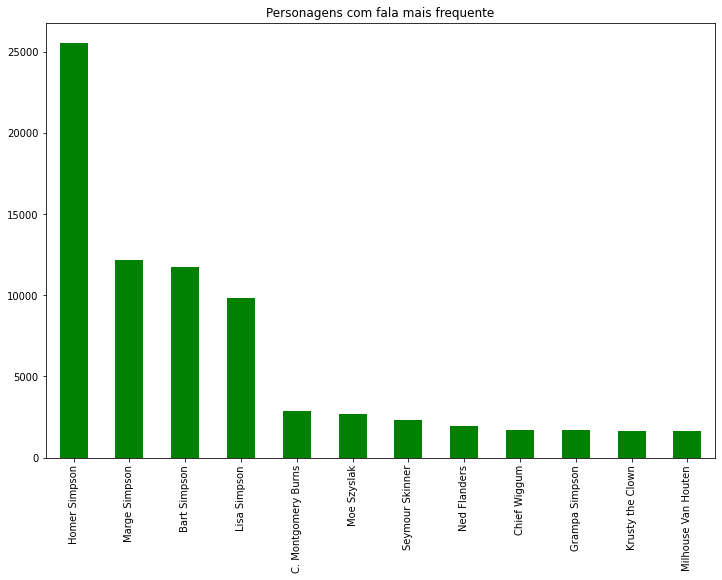

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
df.groupby('character_name')['spoken_words'].count().sort_values(ascending=False).plot(kind='bar', color='g')
ax.set_title('Personagens com fala mais frequente')
ax.set_xlabel('');

In [18]:
# Removendo o nome dos personagens na coluna 'spoken_words'.
df['spoken_words'] = df['spoken_words'].apply(lambda x: x if " - " not in x else x.split(" - ")[1])

In [19]:
import functools
import operator
from nltk.corpus import stopwords

nlp = en_core_web_lg.load()
STOPWORDS = nlp.Defaults.stop_words.union({' ', ''})
lemmatizer = WordNetLemmatizer()

In [20]:
# Função para limpeza dos dados

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9']", " ")
    df[text_field] = df[text_field].str.replace("'","")
    #df[text_field] = [x for x in df[text_field] if x not in STOPWORDS]
    #df[text_field] = [lemmatizer.lemmatize(x) for x in df[text_field]]
    df[text_field] = df[text_field].str.lower()
    return df

In [21]:
#Limpeza e regravação do arquivo de saída limpo
df_simpsons = standardize_text(df, "spoken_words")
df_simpsons.to_csv("df_simpsons_limpo.csv", index = False)
print("Contagem de palavras após o processamento: "+ str(len(df_simpsons['spoken_words'])))

Contagem de palavras após o processamento: 75685


In [22]:
# Removendo stopwords
def remove_stopwords(words):
  cleaned_words = []
  for word in words.split():
    if word not in STOPWORDS:
      cleaned_words.append(word)
  return " ".join(cleaned_words)

df_simpsons['spoken_words'] = df_simpsons['spoken_words'].apply(remove_stopwords)

In [23]:
def tokenize(doc):
    tokenizer = spacy.tokenizer.Tokenizer(nlp.vocab)
    tokens = tokenizer(doc)
    #list_of_tokens = [t for t in tokens if (t.text not in STOPWORDS) and (t.is_punct == False)]
    return (tokens)
  
df_simpsons['tokens'] = df_simpsons['spoken_words'].apply(tokenize)

In [24]:
df_simpsons.head()

,character_id,character_name,spoken_words,tokens
0,1,Marge Simpson,homie night told,"(homie, night, told)"
1,5,Lisa Simpson,looks like traveling tramp steamers produce tr...,"(looks, like, traveling, tramp, steamers, prod..."
2,0,Homer Simpson,whew id hate kids father,"(whew, id, hate, kids, father)"
3,0,Homer Simpson,yes thats real pickle excuse moment,"(yes, thats, real, pickle, excuse, moment)"
4,4,Milhouse Van Houten,hey bart finished organizing stock room,"(hey, bart, finished, organizing, stock, room)"


,Word,Count
0,im,6096
1,oh,5331
2,dont,4500
3,like,3662
4,youre,3181
...,...,...
29121,schwa,1
29122,vintage,1
29123,armstrong,1
29124,grandchildren,1


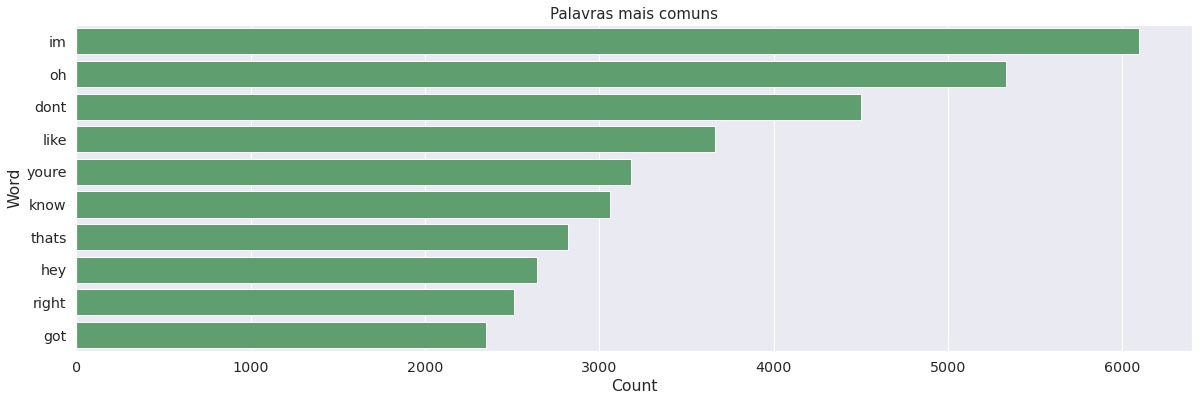

In [25]:
# Palavras mais comuns
words = [x.split() for x in df_simpsons.spoken_words.tolist()]
words = functools.reduce(operator.iconcat, words, [])
wordCountsDF = pd.DataFrame(pd.Series(words).value_counts(), columns=["Count"])
wordCountsDF["Word"] = wordCountsDF.index
wordCountsDF = wordCountsDF[["Word", "Count"]].reset_index(drop=True)
display(wordCountsDF)

sns.set(style="whitegrid")

sns.set(font_scale=1.3)  
sns.barplot(x='Count', y='Word', data=wordCountsDF.head(10), color="g")            
plt.title("Palavras mais comuns", size=15)
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.show()

Gerando nuvem de palavras

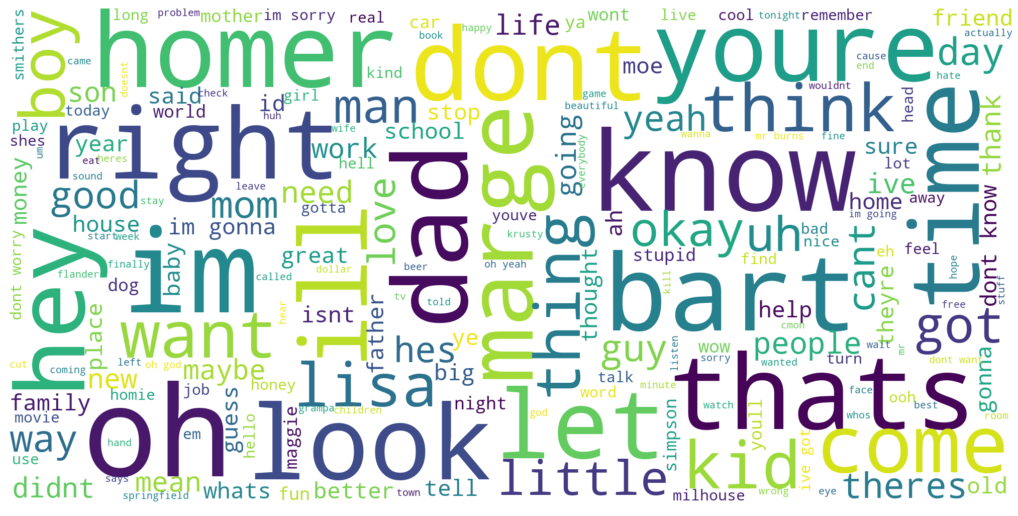

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = list(set(STOPWORDS))


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=50, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(18, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

show_wordcloud(" ".join(words))

In [27]:
#Inspecioanndo novamente os dados
all_words = [word for tokens in df_simpsons["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_simpsons["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

388095 Quantidade total de palavras, com um vocabulario de 388095
Tamanho máximo de uma sentença 79


Com que frequencias as palavras "homer", "simpson", "marge", "bart", "lisa" foram usados ​​ao longo do diálogo?

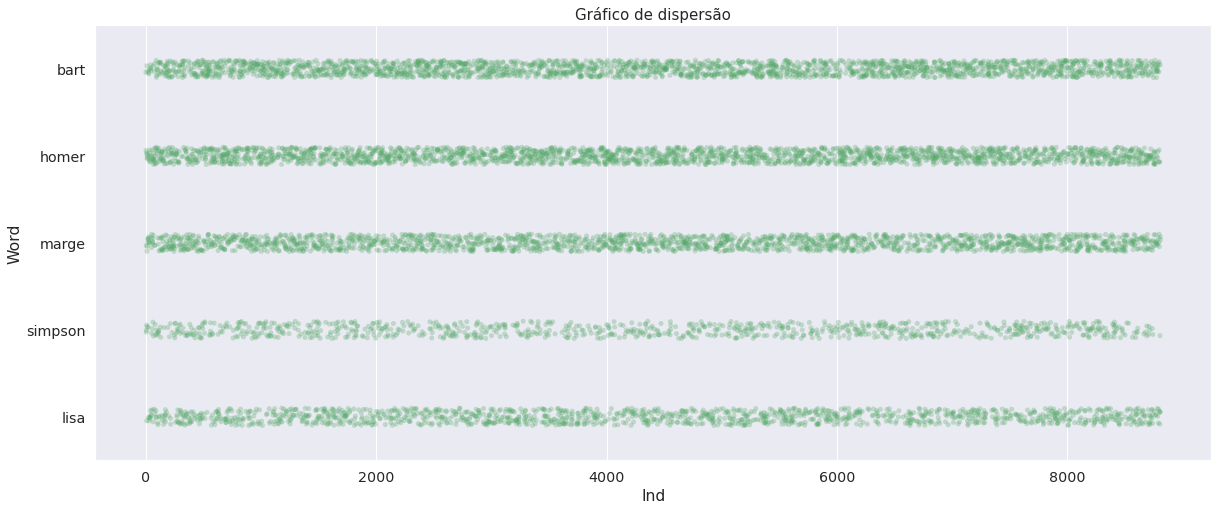

In [28]:
tt= wordCountsDF.head(10).Word.tolist()
tt = ["homer", "marge", "bart", "lisa", "simpson"]

wordsTemp = [x for x in words if x in tt]
tempdf = pd.DataFrame(wordsTemp, columns=["Word"])
tempdf["Ind"] = tempdf.index

sns.set(style="whitegrid")

tt= wordCountsDF.Word.head(10)
wordsTemp = [x for x in words if x in tt]
sns.set(font_scale=1.3)  
sns.stripplot(x="Ind", y="Word", data=tempdf, color="g", alpha=0.3)            
plt.title("Gráfico de dispersão", size=15)
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()

Principais palavras mais importantes para a família Simpson (os que falam).

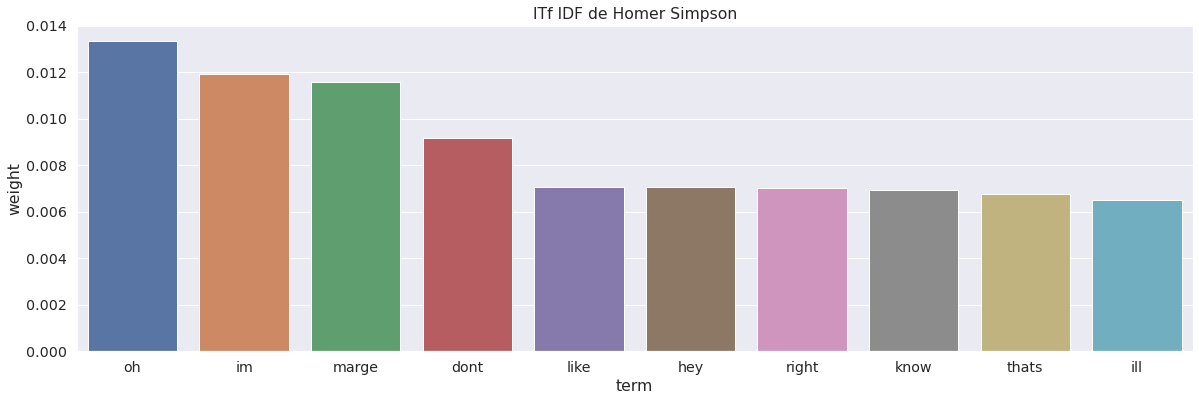

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

txt1 = [x for x in df_simpsons if str(x)!="nan"]
txt1 = df_simpsons[df_simpsons.character_name=="Homer Simpson"].spoken_words.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF de Homer Simpson")
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

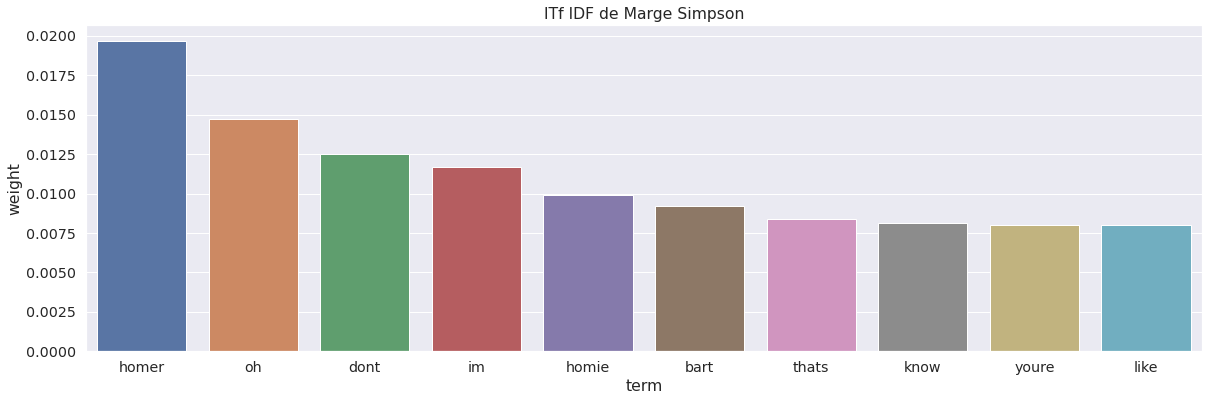

In [30]:
txt1 = [x for x in df_simpsons if str(x)!="nan"]
txt1 = df_simpsons[df_simpsons.character_name=="Marge Simpson"].spoken_words.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF de Marge Simpson")
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

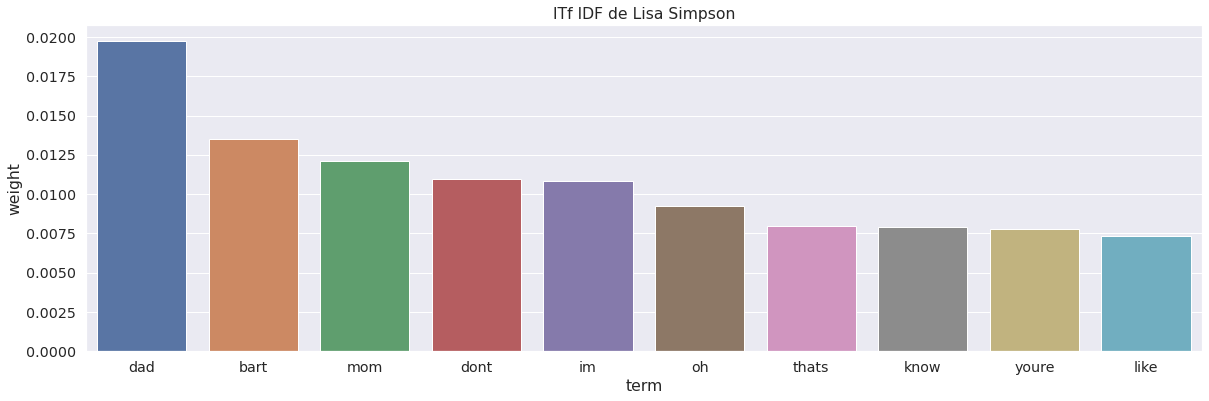

In [31]:
txt1 = [x for x in df_simpsons if str(x)!="nan"]
txt1 = df_simpsons[df_simpsons.character_name=="Lisa Simpson"].spoken_words.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF de Lisa Simpson")
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

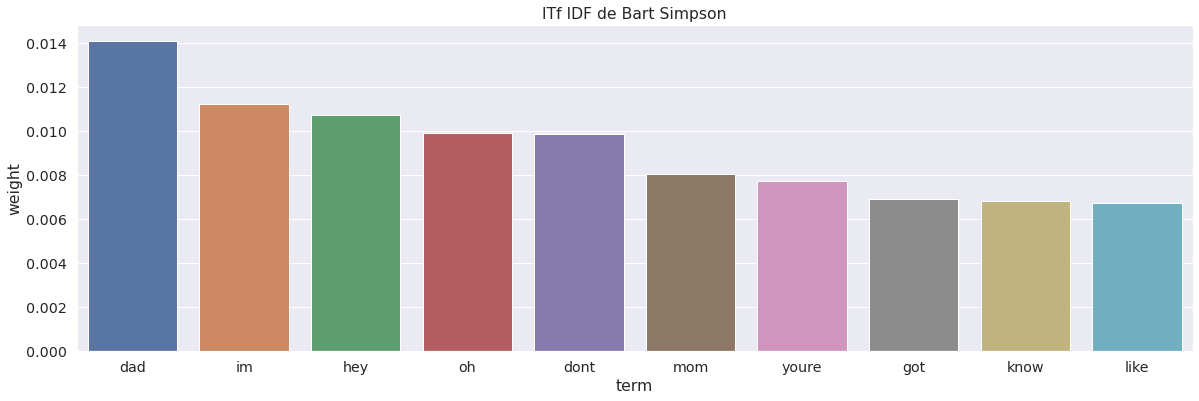

In [32]:
txt1 = [x for x in df_simpsons if str(x)!="nan"]
txt1 = df_simpsons[df_simpsons.character_name=="Bart Simpson"].spoken_words.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF de Bart Simpson")
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

Exploramos as palavras mais importantes para os personagens principais. Agora, vamos explorar a relação entre as palavras.

In [33]:
# N-grams = 2
from nltk.util import ngrams
import collections
import itertools

ngrams = list([nltk.ngrams(words, 2)])

bigrams = list(itertools.chain(*ngrams))

bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

display(bigram_df.head(10))

,bigram,count
0,"(im, gonna)",646
1,"(dont, know)",533
2,"(im, sorry)",420
3,"(ive, got)",407
4,"(dont, worry)",364
5,"(oh, god)",335
6,"(dont, want)",327
7,"(mr, burns)",295
8,"(im, going)",279
9,"(oh, yeah)",271


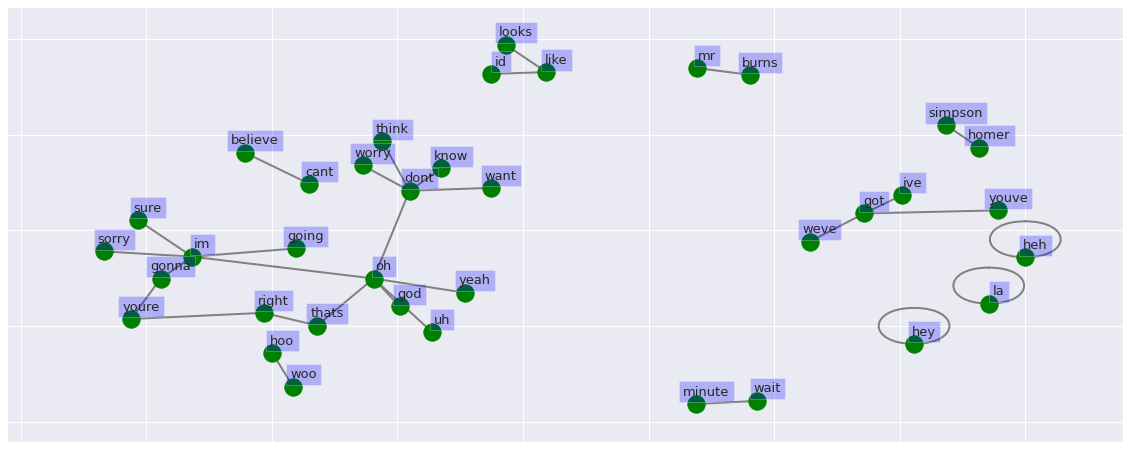

In [34]:
### Visualizando a rede de conexões

import networkx as nx

def visulaizeBigrams(bigram_df, K):
    d = bigram_df.set_index('bigram').T.to_dict('records')

    G = nx.Graph()

    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(20, 8))
    
    pos = nx.spring_layout(G, k=K)

    nx.draw_networkx(G, pos,
                     font_size=13,
                     width=2,
                     edge_color='grey',
                     node_color='green',
                     with_labels = False,
                     ax=ax)

    for key, value in pos.items():
        x, y = value[0]+.02, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='blue', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    plt.grid(True)
    plt.show()
    
visulaizeBigrams(bigram_df=bigram_df,  K=5)

Fazendo uma rede de conexões para uma palavra específica.

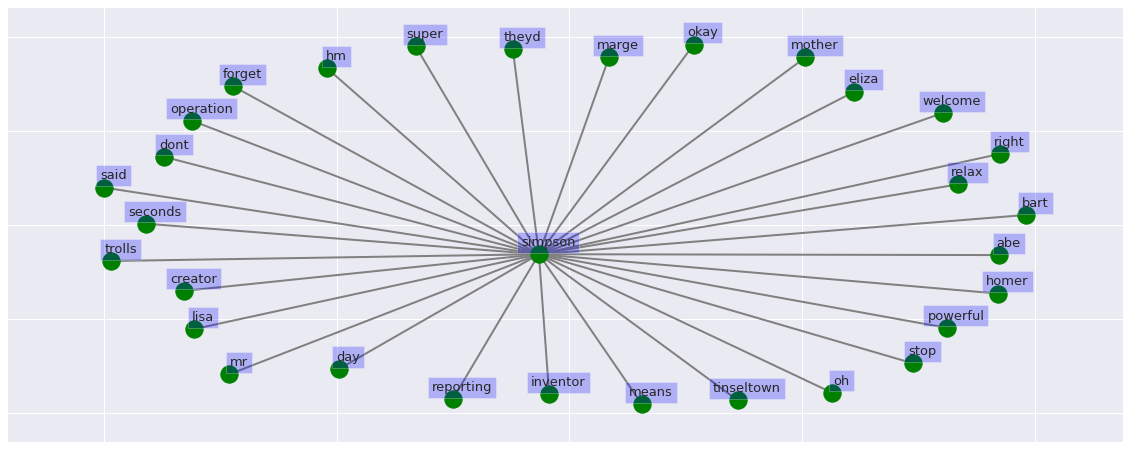

In [35]:
# Fazendo gráfico apenas para palavra "simpson"

wordGToGraph = "simpson"
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

bigram_counts_filter = []
for k in bigram_counts:
    #print(k)
    if wordGToGraph in k:
        bigram_counts_filter.append(k)
        
bigram_counts_filter = collections.Counter(bigram_counts_filter)
bigram_df_filter = pd.DataFrame(bigram_counts_filter.most_common(30), columns=['bigram', 'count'])
visulaizeBigrams(bigram_df=bigram_df_filter,  K=5)

Análise de sentimento

In [36]:
from textblob import TextBlob

# Calculando sentimentos para todos
df_simpsons["Sentiment"] = [TextBlob(x).sentiment.polarity for x in df_simpsons.spoken_words]

In [37]:
topCharactersNames = personagens.character_name.tolist()
dfCleanedTopCharacters = df_simpsons[df_simpsons.character_name.isin(topCharactersNames)]

In [38]:
### principais sentimentos positivos são de
dfCleanedTopCharacters.sort_values("Sentiment").tail().reset_index(drop=True)

,character_id,character_name,spoken_words,tokens,Sentiment
0,2,C. Montgomery Burns,dont dare sully moment price taggery perfect,"(dont, dare, sully, moment, price, taggery, pe...",1.0
1,1,Marge Simpson,hope best thing happened forgetting,"(hope, best, thing, happened, forgetting)",1.0
2,11,Seymour Skinner,cases floor best oh look comes lumpy school snake,"(cases, floor, best, oh, look, comes, lumpy, s...",1.0
3,2,C. Montgomery Burns,hear excellent excellent,"(hear, excellent, excellent)",1.0
4,0,Homer Simpson,yep mother legendary party couple like scott z...,"(yep, mother, legendary, party, couple, like, ...",1.0


In [39]:
### principais sentimentos negativos são de
dfCleanedTopCharacters.sort_values("Sentiment").head().reset_index(drop=True)

,character_id,character_name,spoken_words,tokens,Sentiment
0,0,Homer Simpson,hes loser hes pathetic hes,"(hes, loser, hes, pathetic, hes)",-1.0
1,9,Moe Szyslak,hmm looks like character gets evil contessa,"(hmm, looks, like, character, gets, evil, cont...",-1.0
2,5,Lisa Simpson,toy company evil,"(toy, company, evil)",-1.0
3,9,Moe Szyslak,boy place gotten grim im gonna ive drink,"(boy, place, gotten, grim, im, gonna, ive, drink)",-1.0
4,5,Lisa Simpson,cant dad cruel,"(cant, dad, cruel)",-1.0


Sentimento por personagem

In [40]:
sentimateByName = dfCleanedTopCharacters[dfCleanedTopCharacters.Sentiment.abs()>=0.05].groupby("character_name", as_index=False).mean()
sentimateByName = sentimateByName.sort_values("Sentiment", ascending=False).reset_index(drop=True)

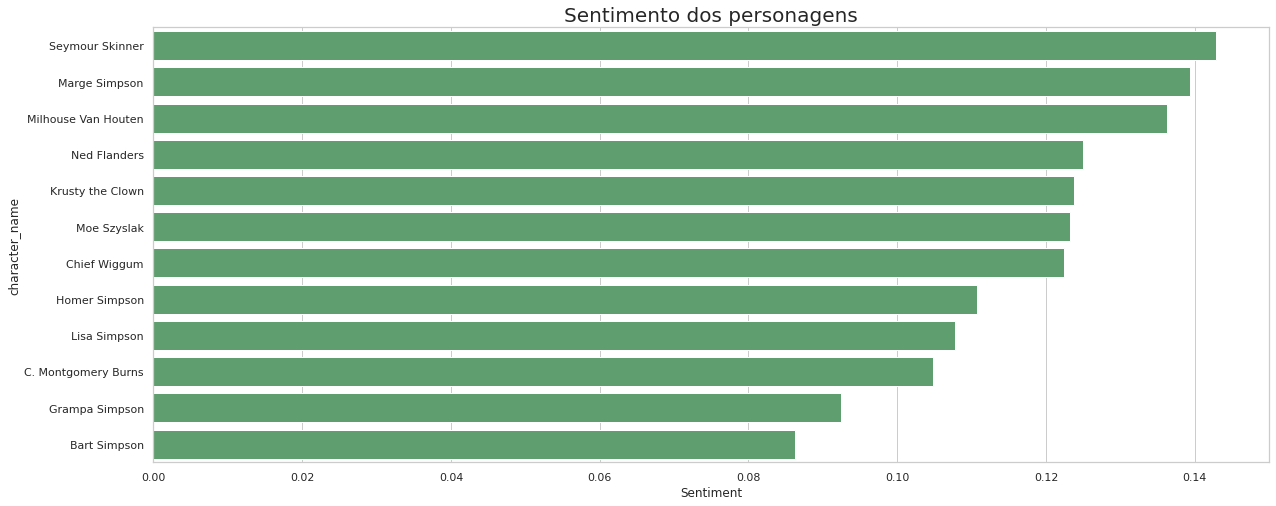

In [41]:
sns.set(style="whitegrid")

tempSentiment = sentimateByName.head(15)
tempSentiment = tempSentiment.append(sentimateByName.tail(15)).reset_index(drop=True)

sns.barplot(x='Sentiment', y='character_name', data=tempSentiment, color="g")            
plt.title("Sentimento dos personagens", size=20)
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()

## Similaridade das palavras com os personagens.

Treinando o modelo

In [42]:
import multiprocessing

from gensim.models import Word2Vec

In [43]:
def processSentence2(spoken_words):
    ww = spoken_words.split()
    #ww = nltk.word_tokenize(spoken_words)
    ww = [x for x in ww if x not in STOPWORDS]
    ww = [x for x in ww if x !=""]
    #ww = [lemmatizer.lemmatize(x) for x in ww]
    if len(ww)>2:
        return " ".join(ww)
    else:
        return np.nan

cleaned2 = [processSentence2(x) for x in df_simpsons.spoken_words.tolist()]
words22 = [x for x in cleaned2 if str(x)!="nan"]

In [44]:
cores = multiprocessing.cpu_count() 
words33 = [x.split() for x in words22]

In [45]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg = 1)

w2v_model.build_vocab(words33, progress_per=10000)

vocab_size = len(w2v_model.wv.vocab)

In [46]:
st = datetime.now()

w2v_model.train(words33, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

print('Time train: ' +  str(datetime.now()-st))

Time train: 0:01:21.793287


In [47]:
w2v_model.init_sims(replace=True)

Explorando o modelo

In [48]:
w2v_model.wv.most_similar(positive=["simpson"])

[('hello', 0.3958399295806885),
 ('right', 0.3808322250843048),
 ('homer', 0.37578585743904114),
 ('yes', 0.373096227645874),
 ('look', 0.36840805411338806),
 ('uh', 0.36608394980430603),
 ('welcome', 0.3577572703361511),
 ('congratulations', 0.353215754032135),
 ('hi', 0.34624457359313965),
 ('dear', 0.34049201011657715)]

In [49]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.5124119520187378),
 ('dad', 0.466683030128479),
 ('bart', 0.4606146216392517),
 ('lisa', 0.4519778788089752),
 ('know', 0.42309972643852234),
 ('moe', 0.41459375619888306),
 ('hey', 0.41130074858665466),
 ('little', 0.4060741066932678),
 ('honey', 0.40240713953971863),
 ('ya', 0.3989678919315338)]

In [50]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.5124119520187378),
 ('dad', 0.478457510471344),
 ('cant', 0.4652749300003052),
 ('homie', 0.46525073051452637),
 ('im', 0.4510645568370819),
 ('kids', 0.45008474588394165),
 ('bart', 0.4448450207710266),
 ('mom', 0.4434052109718323),
 ('know', 0.4416411817073822),
 ('lisa', 0.434292733669281)]

In [51]:
w2v_model.wv.most_similar(positive=["lisa"])

[('bart', 0.6252931952476501),
 ('okay', 0.49045950174331665),
 ('maggie', 0.49032366275787354),
 ('dad', 0.4801078736782074),
 ('mom', 0.4797971844673157),
 ('honey', 0.4710175096988678),
 ('homer', 0.4519778788089752),
 ('marge', 0.434292733669281),
 ('mother', 0.4219759702682495),
 ('im', 0.41858333349227905)]

In [52]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.6252931952476501),
 ('dad', 0.5382163524627686),
 ('mom', 0.515615701675415),
 ('boy', 0.5046191215515137),
 ('okay', 0.4737586975097656),
 ('milhouse', 0.46229448914527893),
 ('homer', 0.4606146216392517),
 ('maggie', 0.4605432152748108),
 ('son', 0.45851778984069824),
 ('homie', 0.45090359449386597)]

Quão semelhantes são duas palavras entre si?

In [53]:
w2v_model.wv.similarity('maggie', 'baby')

0.42528605

In [54]:
w2v_model.wv.similarity('homer', 'dad')

0.466683

In [55]:
w2v_model.wv.similarity('marge', 'mom')

0.4434052

Relações entre nomes de personagens.

In [56]:
### Visualizando os personagens
characters = personagens.character_name.tolist()
characters = [re.sub("[^A-Za-z.']+", ' ', str(row)).lower() for row in characters]
characters = [re.sub("[/']", '', str(row)) for row in characters]
characters = sum([x.split() for x in characters], [])
characters = np.unique([x for x in characters if len(x)>2 and "." not in x ])
characters = [x for x in characters if x in w2v_model.wv.vocab]

In [57]:
X = w2v_model[characters]

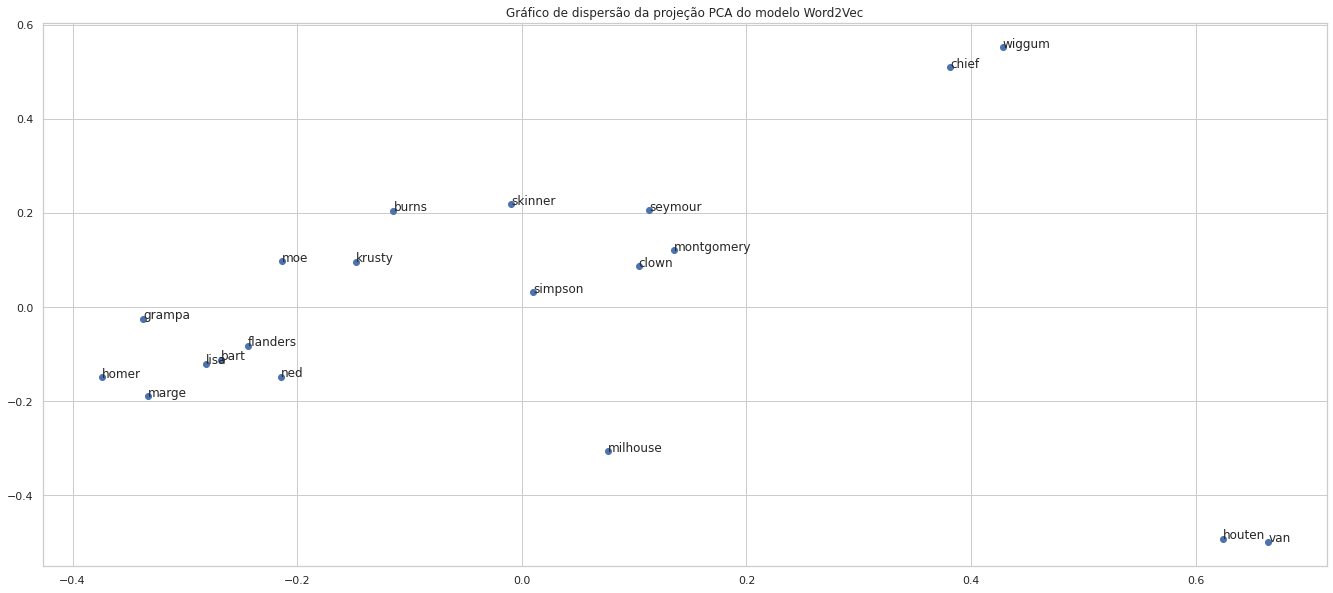

In [58]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

result = pca.fit_transform(X)

fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot(111)
ax.scatter(result[:, 0], result[:, 1])
ax.set_title("Gráfico de dispersão da projeção PCA do modelo Word2Vec")
for i, word in enumerate(characters):
    ax.annotate(word, xy=(result[i, 0]+0.0001, result[i, 1]))
plt.show()

10 palavras mais semelhantes vs. 8 palavras mais aleatórias:

In [59]:
def tsnescatterplot(model, word, list_names):
    
    sns.set_style("darkgrid")

    from sklearn.manifold import TSNE

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(15, 7)
    
    sns.set(font_scale=1.3)  
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()), size=20)
    

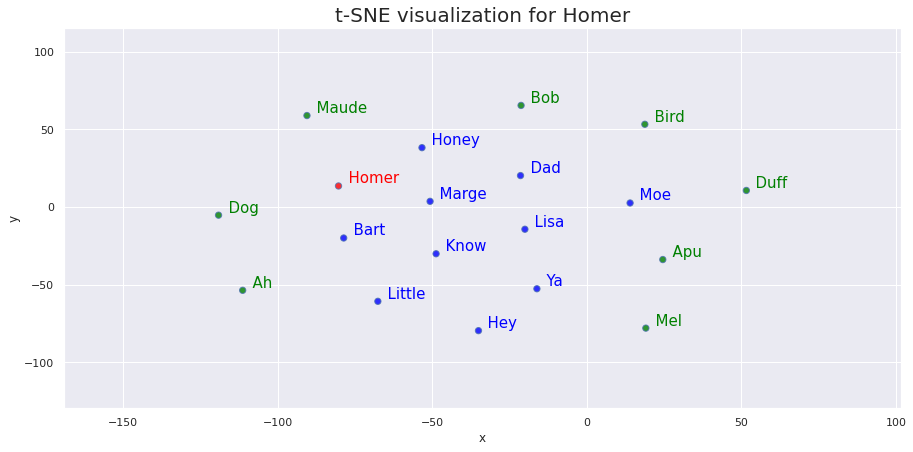

In [60]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

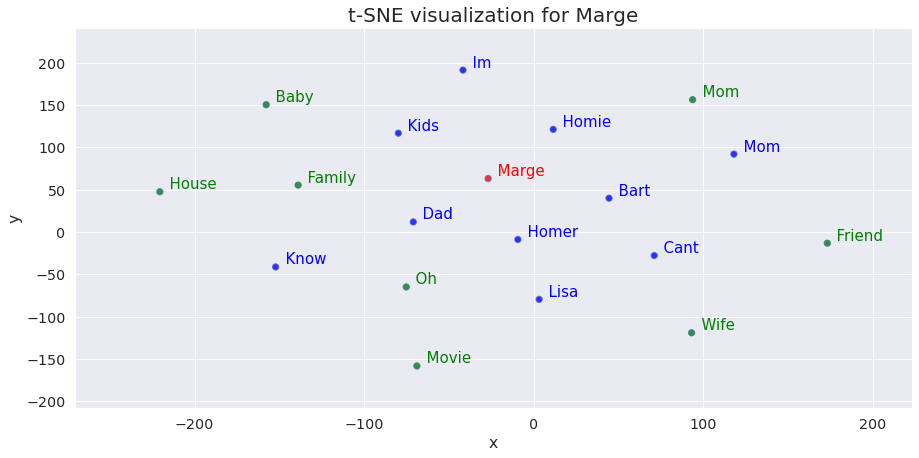

In [61]:
tsnescatterplot(w2v_model, 'marge', ['house', 'mom', 'oh', 'movie', 'baby', 'friend', 'family', 'wife'])

## Machine Learning

Carregando o Dataset

In [64]:
# Limpeza e Removendo o nome dos personagens na coluna 'spoken_words'.
simpsons_train['spoken_words'] = simpsons_train['spoken_words'].apply(lambda x: x if " - " not in x else x.split(" - ")[1])
simpsons_train = standardize_text(simpsons_train, "spoken_words")
#simpsons_train['spoken_words'] = simpsons_train['spoken_words'].apply(remove_stopwords)
#simpsons_train['tokens'] = simpsons_train['spoken_words'].apply(tokenize)
simpsons_train = pd.get_dummies(simpsons_train, columns = ['character_id'])

In [65]:
# Limpeza e Removendo o nome dos personagens na coluna 'spoken_words'.
simpsons_test['spoken_words'] = simpsons_test['spoken_words'].apply(lambda x: x if " - " not in x else x.split(" - ")[1])
simpsons_test = pd.get_dummies(simpsons_test, columns = ['character_id'])

Criando os conjuntos de treinamento e teste.

In [66]:
labels_columns = [
 'character_id_0',
 'character_id_1',
 'character_id_2',
 'character_id_3',
 'character_id_4',
 'character_id_5',
 'character_id_6',
 'character_id_7',
 'character_id_8',
 'character_id_9',
 'character_id_10',
 'character_id_11']


In [67]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(simpsons_train, 
                                                                   'spoken_words',
                                                                   label_columns=labels_columns,
                                                                   maxlen=64, 
                                                                   preprocess_mode='bert')

['character_id_0', 'character_id_1', 'character_id_2', 'character_id_3', 'character_id_4', 'character_id_5', 'character_id_6', 'character_id_7', 'character_id_8', 'character_id_9', 'character_id_10', 'character_id_11']
       character_id_0  character_id_1  character_id_2  character_id_3  \
5682                1               0               0               0   
16381               1               0               0               0   
7538                0               0               0               0   
36107               0               0               0               1   
1484                0               0               0               0   

       character_id_4  character_id_5  character_id_6  character_id_7  \
5682                0               0               0               0   
16381               0               0               0               0   
7538                0               0               0               1   
36107               0               0             

Is Multi-Label? False
preprocessing test...
language: en


In [68]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


Construindo o modelo.

In [69]:
model = text.text_classifier('bert', (x_train, y_train), 
                             preproc=preproc)

Is Multi-Label? False
maxlen is 64
done.


Treinando o modelo.


In [70]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

In [71]:
learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
  16/1420 [..............................] - ETA: 8:34:03 - loss: 3.0471 - accuracy: 0.0273

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = learner.model.predict(x_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))